# Crypto Trading Strategy Monte Carlo Analysis

This notebook performs Monte Carlo simulations on crypto trading strategies, calculating:
- **Monte Carlo Simulation**: Multiple backtest runs to assess strategy robustness
- **Sharpe Ratio**: Risk-adjusted return metric
- **Expected Value**: Expected profit/loss from the strategy


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import datetime, timedelta
import pytz
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully!")

# Load crypto data from .Last.txt files (semicolon-separated format)
# Format: Date Time;Open;High;Low;Close;Volume

data_folders = ["BTCUSD DATA", "ETHUSD DATA", "SOLUSD DATA"]
dfs = []

for folder in data_folders:
    if not os.path.exists(folder):
        print(f"Warning: Folder '{folder}' not found, skipping...")
        continue
    
    # Find all .Last.txt files in the folder
    txt_files = glob.glob(os.path.join(folder, "*.Last.txt"))
    
    for f in txt_files:
        try:
            # Read semicolon-separated file with no header
            df = pd.read_csv(f, sep=';', header=None, 
                           names=['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume'])
            
            # Parse datetime from format: YYYYMMDD HHMMSS
            df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d %H%M%S')
            
            # Set datetime as index and sort
            df = df.set_index('DateTime').sort_index()
            
            # Add ticker name from folder
            ticker = folder.replace(' DATA', '').replace('USD', '')
            df['Ticker'] = ticker
            
            dfs.append(df)
            print(f"Loaded {len(df)} rows from {os.path.basename(f)}")
            
        except Exception as e:
            print(f"Error loading {f}: {e}")

# Concatenate all DataFrames if any were loaded
if len(dfs) > 0:
    price = pd.concat(dfs, ignore_index=False)
    print(f"\nTotal rows loaded: {len(price)}")
    print(f"Date range: {price.index.min()} to {price.index.max()}")
    print(f"\nFirst few rows:")
    print(price.head())
else:
    print("No data files found! Please check the data folders.")
    price = pd.DataFrame()  # Create empty DataFrame to avoid errors



## 2. Backtesting Engine

This class handles backtesting with account rules and risk metrics.


In [ ]:
class CryptoBacktester:
    """
    Backtesting engine for crypto trading strategies with funded account rules.
    """
    
    def __init__(self, account_size=5000, daily_dd_limit=0.02, max_dd_limit=0.03,
                 entry_size=4800, target_gain=500):
        self.account_size = account_size
        self.daily_dd_limit = daily_dd_limit
        self.max_dd_limit = max_dd_limit
        self.entry_size = entry_size
        self.target_gain = target_gain
        
    def run_backtest(self, trades_df, strategy_func=None):
        """
        Run backtest on trades DataFrame.
        
        Parameters:
        -----------
        trades_df : pd.DataFrame
            DataFrame with columns: entry_price, exit_price, entry_time, symbol
        strategy_func : function, optional
            Custom strategy function that returns ('BUY', confidence) or ('HOLD', confidence)
            
        Returns:
        --------
        dict : Backtest results with metrics
        """
        equity_curve = [self.account_size]
        trade_log = []
        current_equity = self.account_size
        peak_equity = self.account_size
        daily_peak = self.account_size
        current_date = None
        
        for _, trade in trades_df.iterrows():
            # Apply strategy if provided
            if strategy_func:
                try:
                    signal, confidence = strategy_func(trade, {'equity': current_equity})
                    if signal != 'BUY':
                        continue
                except:
                    continue
            
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            
            # Calculate PnL
            pnl = self.entry_size * ((exit_price - entry_price) / entry_price)
            new_equity = current_equity + pnl
            
            # Check daily DD
            if daily_peak > 0:
                daily_dd = (daily_peak - new_equity) / daily_peak
                if daily_dd > self.daily_dd_limit:
                    break
            
            # Check max DD
            if peak_equity > 0:
                max_dd = (peak_equity - new_equity) / peak_equity
                if max_dd > self.max_dd_limit:
                    break
            
            current_equity = new_equity
            if current_equity > peak_equity:
                peak_equity = current_equity
            if current_equity > daily_peak:
                daily_peak = current_equity
            
            trade_log.append({
                'entry_price': entry_price,
                'exit_price': exit_price,
                'pnl': pnl,
                'equity': current_equity
            })
            
            equity_curve.append(current_equity)
            
            # Check target gain
            if current_equity - self.account_size >= self.target_gain:
                break
        
        # Calculate metrics
        equity_array = np.array(equity_curve)
        total_pnl = current_equity - self.account_size
        return_pct = (total_pnl / self.account_size) * 100
        
        # Drawdown calculation
        rolling_max = np.maximum.accumulate(equity_array)
        drawdowns = (rolling_max - equity_array) / rolling_max
        max_dd = drawdowns.max() * 100 if len(drawdowns) > 0 else 0
        
        # Returns for Sharpe/Sortino
        returns = np.diff(equity_array) / equity_array[:-1]
        returns = returns[~np.isnan(returns)]
        
        # Sharpe Ratio (annualized, assuming 312 trading days)
        if len(returns) > 1 and returns.std() > 0:
            sharpe = (returns.mean() * np.sqrt(312)) / returns.std()
        else:
            sharpe = 0
        
        # Sortino Ratio (only downside volatility)
        downside_returns = returns[returns < 0]
        if len(downside_returns) > 1 and downside_returns.std() > 0:
            sortino = (returns.mean() * np.sqrt(312)) / downside_returns.std()
        else:
            sortino = 0
        
        # Expected Value (average PnL per trade)
        if len(trade_log) > 0:
            expected_value = np.mean([t['pnl'] for t in trade_log])
        else:
            expected_value = 0
        
        return {
            'final_equity': current_equity,
            'total_pnl': total_pnl,
            'return_pct': return_pct,
            'num_trades': len(trade_log),
            'max_dd_pct': max_dd,
            'sharpe': sharpe,
            'sortino': sortino,
            'expected_value': expected_value,
            'equity_curve': equity_curve,
            'trade_log': trade_log,
            'passed': total_pnl >= self.target_gain and max_dd < self.max_dd_limit * 100
        }

print("Backtesting engine defined!")


## 3. Prepare Trade Data

Convert price data into trade format for backtesting.


In [ ]:
# Prepare trade data from price data
# Filter to trading window (7:30-11:00 AM Chicago time)
CHICAGO_TZ = pytz.timezone('America/Chicago')

def prepare_trades_from_data(price_df, symbol='BTC', sample_interval=5, max_trades=1000):
    """
    Convert price data to trade format.
    """
    # Filter to trading hours
    price_df['chicago_time'] = price_df.index.tz_localize('UTC').tz_convert(CHICAGO_TZ)
    price_df['hour'] = price_df['chicago_time'].dt.hour
    price_df['minute'] = price_df['chicago_time'].dt.minute
    
    # Filter to 7:30-11:00 AM Chicago time
    mask = ((price_df['hour'] == 7) & (price_df['minute'] >= 30)) | \
           ((price_df['hour'] >= 8) & (price_df['hour'] < 11))
    
    window_data = price_df[mask].copy()
    
    if len(window_data) == 0:
        return pd.DataFrame()
    
    # Sample every Nth bar
    window_data = window_data.iloc[::sample_interval].head(max_trades)
    
    # Create trades DataFrame
    trades = []
    for i in range(1, len(window_data)):
        current = window_data.iloc[i]
        previous = window_data.iloc[i-1]
        
        trades.append({
            'symbol': symbol,
            'entry_price': previous['Close'],
            'exit_price': current['Close'],
            'entry_time': previous.name,
            'high': current['High'],
            'low': current['Low'],
            'volume': current['Volume'],
            'price_range': current['High'] - current['Low'],
            'cvd': 0,  # Simplified
            'cvd_ma': 0,
            'recent_high': window_data['High'].iloc[max(0, i-20):i].max(),
            'recent_low': window_data['Low'].iloc[max(0, i-20):i].min(),
        })
    
    return pd.DataFrame(trades)

# Prepare trades for BTC
if len(price) > 0 and 'Ticker' in price.columns:
    btc_data = price[price['Ticker'] == 'BTC'].copy()
    trades_df = prepare_trades_from_data(btc_data, symbol='BTC', sample_interval=5, max_trades=500)
    print(f"Prepared {len(trades_df)} trades from BTC data")
    print(f"Date range: {trades_df['entry_time'].min()} to {trades_df['entry_time'].max()}")
else:
    print("No price data available. Please load data first.")
    trades_df = pd.DataFrame()


## 4. Define Trading Strategy

Define your custom trading strategy here. The function should return ('BUY', confidence) or ('HOLD', confidence).


In [ ]:
# Example Strategy: Simple momentum-based strategy
def my_strategy(row, context=None):
    """
    Custom trading strategy.
    
    Parameters:
    -----------
    row : pd.Series
        Trade data with entry_price, exit_price, recent_high, recent_low, etc.
    context : dict, optional
        Additional context like current equity
        
    Returns:
    --------
    tuple: (signal, confidence)
        signal: 'BUY' or 'HOLD'
        confidence: float between 0 and 1
    """
    entry_price = row['entry_price']
    recent_high = row.get('recent_high', entry_price * 1.02)
    recent_low = row.get('recent_low', entry_price * 0.98)
    
    # Simple momentum: Buy when price is near recent high
    if entry_price >= recent_high * 0.99:
        return 'BUY', 0.8
    elif entry_price >= recent_low + (recent_high - recent_low) * 0.7:
        return 'BUY', 0.6
    else:
        return 'HOLD', 0.5

print("Strategy defined! Modify 'my_strategy' function to implement your own strategy.")


## 5. Monte Carlo Simulation

Run multiple backtests with random sampling to assess strategy robustness.


In [ ]:
# Monte Carlo Simulation Parameters
NUM_SIMULATIONS = 500
SAMPLE_SIZE = 100  # Number of trades per simulation

# Initialize backtester
backtester = CryptoBacktester(
    account_size=5000,
    daily_dd_limit=0.02,
    max_dd_limit=0.03,
    entry_size=4800,
    target_gain=500
)

# Run Monte Carlo simulation
print(f"Running {NUM_SIMULATIONS} Monte Carlo simulations...")
results = []

if len(trades_df) > 0:
    for i in range(NUM_SIMULATIONS):
        # Randomly sample trades
        sample_trades = trades_df.sample(n=min(SAMPLE_SIZE, len(trades_df)), replace=True)
        sample_trades = sample_trades.sort_values('entry_time').reset_index(drop=True)
        
        # Run backtest with strategy
        result = backtester.run_backtest(sample_trades, strategy_func=my_strategy)
        results.append(result)
        
        if (i + 1) % 50 == 0:
            print(f"Completed {i + 1}/{NUM_SIMULATIONS} simulations...")
    
    print(f"\n✓ Completed {NUM_SIMULATIONS} simulations!")
else:
    print("No trade data available. Please prepare trades first.")


# Plot each cryptocurrency in separate charts
if 'Ticker' in price.columns and len(price) > 0:
    tickers = sorted(price['Ticker'].unique())
    num_tickers = len(tickers)
    
    # Create subplots - one for each cryptocurrency
    fig, axes = plt.subplots(num_tickers, 1, figsize=(14, 5 * num_tickers))
    
    # If only one ticker, axes won't be an array
    if num_tickers == 1:
        axes = [axes]
    
    for idx, ticker in enumerate(tickers):
        ticker_data = price[price['Ticker'] == ticker]['Close']
        
        axes[idx].plot(ticker_data.index, ticker_data.values, linewidth=1.5, color=f'C{idx}')
        axes[idx].set_title(f'{ticker} Close Price Over Time', fontsize=14, fontweight='bold', pad=10)
        axes[idx].set_xlabel('Date', fontsize=12)
        axes[idx].set_ylabel('Price (USD)', fontsize=12)
        axes[idx].grid(True, alpha=0.3)
        
        # Format x-axis dates
        axes[idx].tick_params(axis='x', rotation=45)
        
        # Add some stats as text
        min_price = ticker_data.min()
        max_price = ticker_data.max()
        current_price = ticker_data.iloc[-1]
        axes[idx].text(0.02, 0.98, f'Min: ${min_price:,.2f} | Max: ${max_price:,.2f} | Current: ${current_price:,.2f}',
                      transform=axes[idx].transAxes, fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
else:
    print("No data available to plot.")

In [ ]:
# Extract metrics from results
if len(results) > 0:
    sharpe_ratios = [r['sharpe'] for r in results]
    sortino_ratios = [r['sortino'] for r in results]
    expected_values = [r['expected_value'] for r in results]
    returns = [r['return_pct'] for r in results]
    max_dds = [r['max_dd_pct'] for r in results]
    pass_rates = [r['passed'] for r in results]
    
    # Calculate statistics
    avg_sharpe = np.mean(sharpe_ratios)
    std_sharpe = np.std(sharpe_ratios)
    median_sharpe = np.median(sharpe_ratios)
    
    avg_sortino = np.mean(sortino_ratios)
    std_sortino = np.std(sortino_ratios)
    
    avg_expected_value = np.mean(expected_values)
    std_expected_value = np.std(expected_values)
    
    pass_rate = np.mean(pass_rates) * 100
    
    # Display results
    print("=" * 60)
    print("MONTE CARLO SIMULATION RESULTS")
    print("=" * 60)
    print(f"\n📊 Pass Rate: {pass_rate:.1f}% ({sum(pass_rates)}/{len(results)} passed)")
    print(f"\n🎯 SHARPE RATIO:")
    print(f"   Average: {avg_sharpe:.3f}")
    print(f"   Median:  {median_sharpe:.3f}")
    print(f"   Std Dev: {std_sharpe:.3f}")
    print(f"   Min:     {np.min(sharpe_ratios):.3f}")
    print(f"   Max:     {np.max(sharpe_ratios):.3f}")
    
    print(f"\n📈 SORTINO RATIO:")
    print(f"   Average: {avg_sortino:.3f}")
    print(f"   Std Dev: {std_sortino:.3f}")
    
    print(f"\n💰 EXPECTED VALUE (Avg PnL per Trade):")
    print(f"   Average: ${avg_expected_value:.2f}")
    print(f"   Std Dev: ${std_expected_value:.2f}")
    print(f"   Min:     ${np.min(expected_values):.2f}")
    print(f"   Max:     ${np.max(expected_values):.2f}")
    
    print(f"\n📉 Other Metrics:")
    print(f"   Avg Return: {np.mean(returns):.2f}%")
    print(f"   Avg Max DD: {np.mean(max_dds):.2f}%")
    print("=" * 60)
else:
    print("No results available. Run Monte Carlo simulation first.")


## 7. Visualizations

Visualize the Monte Carlo results with distributions and key metrics.


In [ ]:
# Create visualizations
if len(results) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Sharpe Ratio Distribution
    axes[0, 0].hist(sharpe_ratios, bins=30, alpha=0.7, color='green', edgecolor='black')
    axes[0, 0].axvline(avg_sharpe, color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_sharpe:.3f}')
    axes[0, 0].axvline(1.0, color='orange', linestyle='--', linewidth=1, label='Good: >1.0')
    axes[0, 0].set_xlabel('Sharpe Ratio', fontsize=12)
    axes[0, 0].set_ylabel('Frequency', fontsize=12)
    axes[0, 0].set_title('Sharpe Ratio Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Expected Value Distribution
    axes[0, 1].hist(expected_values, bins=30, alpha=0.7, color='blue', edgecolor='black')
    axes[0, 1].axvline(avg_expected_value, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: ${avg_expected_value:.2f}')
    axes[0, 1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[0, 1].set_xlabel('Expected Value ($)', fontsize=12)
    axes[0, 1].set_ylabel('Frequency', fontsize=12)
    axes[0, 1].set_title('Expected Value Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Return Distribution
    axes[1, 0].hist(returns, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[1, 0].axvline(np.mean(returns), color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {np.mean(returns):.2f}%')
    axes[1, 0].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    axes[1, 0].set_xlabel('Return (%)', fontsize=12)
    axes[1, 0].set_ylabel('Frequency', fontsize=12)
    axes[1, 0].set_title('Return Distribution', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Sortino Ratio Distribution
    axes[1, 1].hist(sortino_ratios, bins=30, alpha=0.7, color='teal', edgecolor='black')
    axes[1, 1].axvline(avg_sortino, color='red', linestyle='--', linewidth=2, 
                        label=f'Mean: {avg_sortino:.3f}')
    axes[1, 1].axvline(1.0, color='orange', linestyle='--', linewidth=1, label='Good: >1.0')
    axes[1, 1].set_xlabel('Sortino Ratio', fontsize=12)
    axes[1, 1].set_ylabel('Frequency', fontsize=12)
    axes[1, 1].set_title('Sortino Ratio Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary Statistics Table
    print("\n📊 Summary Statistics Table:")
    summary_df = pd.DataFrame({
        'Metric': ['Sharpe Ratio', 'Sortino Ratio', 'Expected Value ($)', 'Return (%)', 'Max DD (%)'],
        'Mean': [f"{avg_sharpe:.3f}", f"{avg_sortino:.3f}", f"${avg_expected_value:.2f}", 
                 f"{np.mean(returns):.2f}", f"{np.mean(max_dds):.2f}"],
        'Std Dev': [f"{std_sharpe:.3f}", f"{std_sortino:.3f}", f"${std_expected_value:.2f}",
                    f"{np.std(returns):.2f}", f"{np.std(max_dds):.2f}"],
        'Min': [f"{np.min(sharpe_ratios):.3f}", f"{np.min(sortino_ratios):.3f}", 
                f"${np.min(expected_values):.2f}", f"{np.min(returns):.2f}", f"{np.min(max_dds):.2f}"],
        'Max': [f"{np.max(sharpe_ratios):.3f}", f"{np.max(sortino_ratios):.3f}",
                f"${np.max(expected_values):.2f}", f"{np.max(returns):.2f}", f"{np.max(max_dds):.2f}"]
    })
    print(summary_df.to_string(index=False))
else:
    print("No results to visualize. Run Monte Carlo simulation first.")


## 8. Summary & Interpretation

### Key Metrics Explained:

- **Sharpe Ratio**: Measures risk-adjusted returns. Values > 1.0 are considered good, > 2.0 are excellent.
- **Sortino Ratio**: Similar to Sharpe but only considers downside volatility. Better for asymmetric return distributions.
- **Expected Value**: Average profit/loss per trade. Positive values indicate profitable strategy on average.
- **Pass Rate**: Percentage of simulations that met the target gain without violating drawdown limits.

### Strategy Assessment:

Based on the Monte Carlo results, you can assess:
1. **Consistency**: Low standard deviation in Sharpe/Expected Value = more consistent
2. **Profitability**: Positive Expected Value = profitable on average
3. **Risk**: Lower Max DD = better risk management
4. **Reliability**: Higher Pass Rate = more likely to succeed in live trading


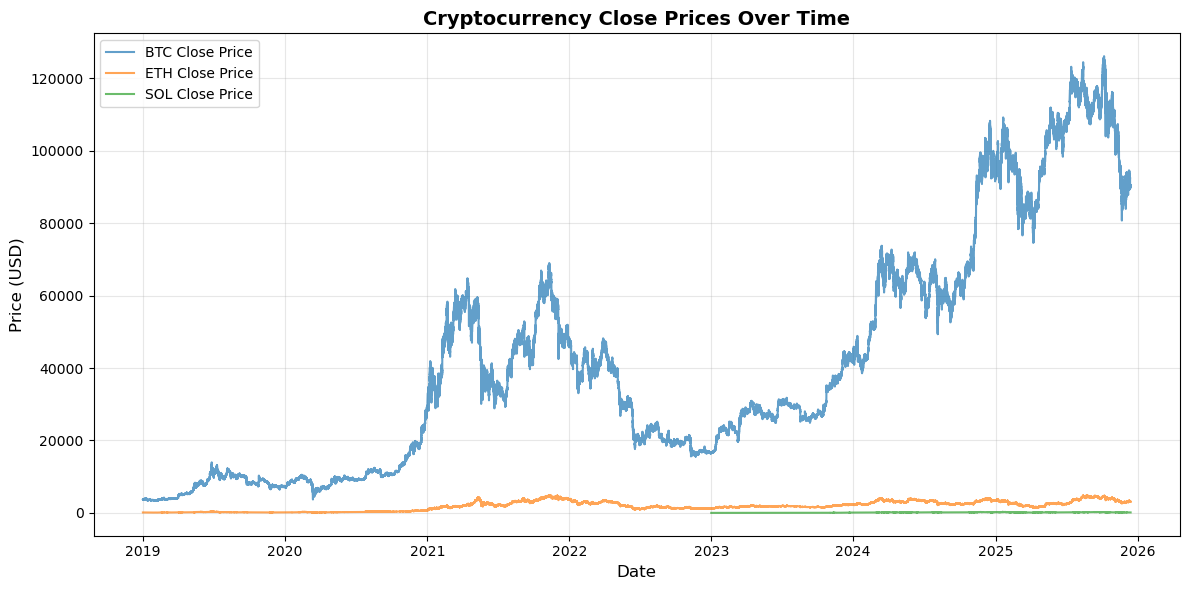

In [ ]:
# Plot Close prices with proper labels
plt.figure(figsize=(12, 6))

# Check if we have multiple tickers
if 'Ticker' in price.columns:
    tickers = price['Ticker'].unique()
    if len(tickers) > 1:
        # Plot each ticker separately with labels
        for ticker in tickers:
            ticker_data = price[price['Ticker'] == ticker]['Close']
            plt.plot(ticker_data.index, ticker_data.values, label=f'{ticker} Close Price', alpha=0.7)
        plt.legend()
        plt.title('Cryptocurrency Close Prices Over Time', fontsize=14, fontweight='bold')
    else:
        # Single ticker
        plt.plot(price['Close'], label=f'{tickers[0]} Close Price')
        plt.legend()
        plt.title(f'{tickers[0]} Close Price Over Time', fontsize=14, fontweight='bold')
else:
    # No ticker column, just plot all data
    plt.plot(price['Close'], label='Close Price')
    plt.legend()
    plt.title('Close Price Over Time', fontsize=14, fontweight='bold')

plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()